###  Kung-Fu  actor-critic

[Kung-Fu Master](https://gym.openai.com/envs/KungFuMaster-v0/) and train it with Advantage Actor-Critic.

![https://upload.wikimedia.org/wikipedia/en/6/66/Kung_fu_master_mame.png](https://upload.wikimedia.org/wikipedia/en/6/66/Kung_fu_master_mame.png)

In [0]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

 
* Image resized to 42x42 and converted to grayscale to run faster
* Agent sees last 4 frames of game to account for object velocity

In [ ]:
import numpy as np
import gym
from scipy.misc import imresize
import logger
import seeding


class Space(object):
    
    def __init__(self, shape=None, dtype=None):
        import numpy as np  
        self.shape = None if shape is None else tuple(shape)
        self.dtype = None if dtype is None else np.dtype(dtype)
        self.np_random = None
        self.seed()

    def sample(self):
       
        raise NotImplementedError

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def contains(self, x):

        raise NotImplementedError

    def __contains__(self, x):
        return self.contains(x)

    def to_jsonable(self, sample_n):
       
        return sample_n

    def from_jsonable(self, sample_n):
        
        return sample_n
class Box(Space):
   
    def __init__(self, low, high, shape=None, dtype=np.float32):
        assert dtype is not None, 'dtype must be explicitly provided. '
        self.dtype = np.dtype(dtype)

        if shape is not None:
            shape = tuple(shape)
            assert np.isscalar(low) or low.shape == shape, "low.shape doesn't match provided shape"
            assert np.isscalar(high) or high.shape == shape, "high.shape doesn't match provided shape"
        elif not np.isscalar(low):
            shape = low.shape
            assert np.isscalar(high) or high.shape == shape, "high.shape doesn't match low.shape"
        elif not np.isscalar(high):
            shape = high.shape
            assert np.isscalar(low) or low.shape == shape, "low.shape doesn't match high.shape"
        else:
            raise ValueError("shape must be provided or inferred from the shapes of low or high")

        if np.isscalar(low):
            low = np.full(shape, low, dtype=dtype)

        if np.isscalar(high):
            high = np.full(shape, high, dtype=dtype)

        self.shape = shape
        self.low = low
        self.high = high

        def _get_precision(dtype):
            if np.issubdtype(dtype, np.floating):
                return np.finfo(dtype).precision
            else:
                return np.inf
        low_precision = _get_precision(self.low.dtype)
        high_precision = _get_precision(self.high.dtype)
        dtype_precision = _get_precision(self.dtype)
        if min(low_precision, high_precision) > dtype_precision:
            logger.warn("Box bound precision lowered by casting to {}".format(self.dtype))
        self.low = self.low.astype(self.dtype)
        self.high = self.high.astype(self.dtype)

        # Boolean arrays which indicate the interval type for each coordinate
        self.bounded_below = -np.inf < self.low
        self.bounded_above = np.inf > self.high

        super(Box, self).__init__(self.shape, self.dtype)

    def is_bounded(self, manner="both"):
        below = np.all(self.bounded_below)
        above = np.all(self.bounded_above)
        if manner == "both":
            return below and above
        elif manner == "below":
            return below
        elif manner == "above":
            return above
        else:
            raise ValueError("manner is not in {'below', 'above', 'both'}")

    def sample(self):
     
        high = self.high if self.dtype.kind == 'f' \
                else self.high.astype('int64') + 1
        sample = np.empty(self.shape)

        # Masking arrays which classify the coordinates according to interval
        # type
        unbounded   = ~self.bounded_below & ~self.bounded_above
        upp_bounded = ~self.bounded_below &  self.bounded_above
        low_bounded =  self.bounded_below & ~self.bounded_above
        bounded     =  self.bounded_below &  self.bounded_above


        # Vectorized sampling by interval type
        sample[unbounded] = self.np_random.normal(
                size=unbounded[unbounded].shape)

        sample[low_bounded] = self.np_random.exponential(
            size=low_bounded[low_bounded].shape) + self.low[low_bounded]

        sample[upp_bounded] = -self.np_random.exponential(
            size=upp_bounded[upp_bounded].shape) + self.high[upp_bounded]

        sample[bounded] = self.np_random.uniform(low=self.low[bounded],
                                            high=high[bounded],
                                            size=bounded[bounded].shape)
        if self.dtype.kind == 'i':
            sample = np.floor(sample)

        return sample.astype(self.dtype)

    def contains(self, x):
        if isinstance(x, list):
            x = np.array(x)  # Promote list to array for contains check
        return x.shape == self.shape and np.all(x >= self.low) and np.all(x <= self.high)

    def to_jsonable(self, sample_n):
        return np.array(sample_n).tolist()

    def from_jsonable(self, sample_n):
        return [np.asarray(sample) for sample in sample_n]

    def __repr__(self):
        return "Box" + str(self.shape)

    def __eq__(self, other):
        return isinstance(other, Box) and (self.shape == other.shape) and np.allclose(self.low, other.low) and np.allclose(self.high, other.high)
class Wrapper(Env):
    """Wraps the environment to allow a modular transformation.
    
 """
    def __init__(self, env):
        self.env = env
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        self.reward_range = self.env.reward_range
        self.metadata = self.env.metadata

    def __getattr__(self, name):
        if name.startswith('_'):
            raise AttributeError("attempted to get missing private attribute '{}'".format(name))
        return getattr(self.env, name)

    @property
    def spec(self):
        return self.env.spec

    @classmethod
    def class_name(cls):
        return cls.__name__

    def step(self, action):
        return self.env.step(action)

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def render(self, mode='human', **kwargs):
        return self.env.render(mode, **kwargs)

    def close(self):
        return self.env.close()

    def seed(self, seed=None):
        return self.env.seed(seed)

    def compute_reward(self, achieved_goal, desired_goal, info):
        return self.env.compute_reward(achieved_goal, desired_goal, info)

    def __str__(self):
        return '<{}{}>'.format(type(self).__name__, self.env)

    def __repr__(self):
        return str(self)

    @property
    def unwrapped(self):
        return self.env.unwrapped
class Preprocessingbreakout(Wrapper):
    def __init__(self, env, height=42, width=42, color=False, crop=lambda img: img, 
                 n_frames=4, dim_order='theano', reward_scale=1,):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(Preprocessingbreakout, self).__init__(env)
        assert dim_order in ('theano', 'tensorflow')
        self.img_size = (height, width)
        self.crop=crop
        self.color=color
        self.dim_order = dim_order
        self.reward_scale = reward_scale
        
        n_channels = (3 * n_frames) if color else n_frames
        obs_shape = [n_channels,height,width] if dim_order == 'theano' else [height,width,n_channels]
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self,action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward * self.reward_scale, done, info
    
    # image processing 
    
    def update_buffer(self,img):
        img = self.preproc_image(img)
        offset = 3 if self.color else 1
        if self.dim_order == 'theano':
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        else:
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

    def preproc_image(self, img):
        img = self.crop(img)
        img = imresize(img, self.img_size)
        if not self.color:
            img = img.mean(-1, keepdims=True)
        if self.dim_order == 'theano':
            img = img.transpose([2,0,1]) # [h, w, c] to [c, h, w]
        img = img.astype('float32') / 255.
        return img

In [0]:
import gym

def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = Preprocessingbreakout(
        env, height=42, width=42,
        crop=lambda img: img[60:-30, 5:],
        dim_order='tensorflow',
        color=False, n_frames=4)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (42, 42, 4)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


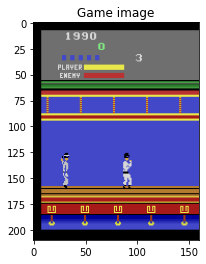

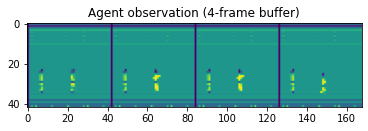

In [0]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([0, 2, 1]).reshape([42,-1]))
plt.show()

### Build an agent

 


 

In [0]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [0]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Input

Using TensorFlow backend.


In [0]:
from keras.layers import Conv2D, Dense, Flatten, Input
import keras
from keras.models import Model, Sequential

class Agent:
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        
        with tf.variable_scope(name, reuse=reuse):
            
             Prepare neural network architecture

            inputs = Input(shape=state_shape)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(inputs)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)
            x = Flatten()(x)
            x = Dense(128, activation='relu')(x)
            
            # two different output layers
            logits = Dense(n_actions, activation='linear')(x)
            state_value = Dense(1, activation='linear')(x)
            
            self.network = Model(inputs=inputs, outputs=[logits, state_value])
            
            
            #  graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)
        
    def symbolic_step(self, state_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""
        
        # apply agent's neural network to get policy logits and state values.

        
        
        logits, state_value = self.network(state_t)
        state_value = state_value[:, 0]
        
        assert tf.is_numeric_tensor(state_value) and state_value.shape.ndims == 1, \
            "please return 1D tf tensor of state values [you got %s]" % repr(state_value)
        assert tf.is_numeric_tensor(logits) and logits.shape.ndims == 2, \
            "please return 2d tf tensor of logits [you got %s]" % repr(logits)
        
        return (logits, state_value)
    
    def step(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.agent_outputs, {self.state_t: state_t})
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

In [0]:
agent = Agent("agent", obs_shape, n_actions)
sess.run(tf.global_variables_initializer())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
state = [env.reset()]
logits, value = agent.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 [[-0.0369496  -0.01874884 -0.00143453 -0.02603986  0.04033006 -0.05537146
  -0.03294876  0.01101714  0.03151176 -0.00100702  0.00829301  0.01963131
   0.04307696  0.00434048]]
state values:
 [0.03718236]


### Play
Measures agent's average reward.

In [0]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()

        total_reward = 0
        while True:
            action = agent.sample_actions(agent.step([state]))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

In [0]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
rewards = evaluate(agent, env_monitor, n_games=3)
env_monitor.close()

print(rewards)

[900.0, 200.0, 1200.0]


In [0]:
import os

from IPython.display import HTML

video_names = [s for s in os.listdir("./kungfu_videos/") if s.endswith(".mp4")]

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/" + video_names[-1]))  

### Training on parallel games

![img](https://s7.postimg.cc/4y36s2b2z/env_pool.png)


To make actor-critic training more stable, I shall play several games in parallel.  

In [0]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):

        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        
        # reset environments automatically
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

__Let's try it out:__

In [0]:
env_batch = EnvBatch(10)

batch_states = env_batch.reset()

batch_actions = agent.sample_actions(agent.step(batch_states))

batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions)
print("Rewards:", batch_rewards)
print("Done:", batch_done)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


State shape: (10, 42, 42, 4)
Actions: [ 4 10  6  3  4  0 13 10  1 10]
Rewards: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Done: [False False False False False False False False False False]


# Actor-critic

Define loss functions and learning algorithms as usual.

In [0]:
states_ph = tf.placeholder('float32', [None,] + list(obs_shape))    
next_states_ph = tf.placeholder('float32', [None,] + list(obs_shape))
actions_ph = tf.placeholder('int32', (None,))
rewards_ph = tf.placeholder('float32', (None,))
is_done_ph = tf.placeholder('float32', (None,))

In [0]:

logits, state_values = agent.symbolic_step(states_ph)
next_logits, next_state_values = agent.symbolic_step(next_states_ph)

# There is no next state if the episode is done!
next_state_values = next_state_values * (1 - is_done_ph)

probs = tf.nn.softmax(logits, axis=-1)            # [n_envs, n_actions]
logprobs = tf.nn.log_softmax(logits, axis=-1)     # [n_envs, n_actions]

logp_actions = tf.reduce_sum(logprobs * tf.one_hot(actions_ph, n_actions), axis=-1) # [n_envs,]

In [0]:
# compute advantage using rewards_ph, state_values and next_state_values
gamma = 0.99
advantage = rewards_ph + gamma*next_state_values - state_values

assert advantage.shape.ndims == 1, "please compute advantage for each sample, vector of shape [n_envs,]"

entropy =  -tf.reduce_sum(probs * logprobs, 1, name="entropy")

assert entropy.shape.ndims == 1, "please compute pointwise entropy vector of shape [n_envs,] "



actor_loss =  - tf.reduce_mean(logp_actions * tf.stop_gradient(advantage)) - 0.001 * tf.reduce_mean(entropy)

target_state_values = rewards_ph+gamma*next_state_values

critic_loss = tf.reduce_mean((state_values - tf.stop_gradient(target_state_values))**2 )

train_step = tf.train.AdamOptimizer(1e-4).minimize(actor_loss + critic_loss)
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
l_act, l_crit, adv, ent = sess.run([actor_loss, critic_loss, advantage, entropy], feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    })

assert abs(l_act) < 100 and abs(l_crit) < 100, "losses seem abnormally large"
assert 0 <= ent.mean() <= np.log(n_actions), "impossible entropy value, double-check the formula pls"
if ent.mean() < np.log(n_actions) / 2:
    print("Entropy is too low for untrained agent")
print("You just might be fine!")

You just might be fine!


# Train 

 


In [0]:
import pandas as pd

def ewma(x, span=100):
    return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


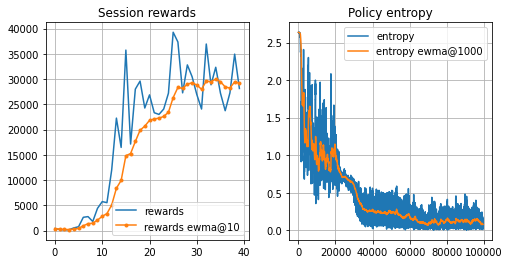

100%|██████████| 100000/100000 [59:22<00:00, 28.07it/s]


In [0]:
import tqdm
from IPython.display import clear_output

with tqdm.trange(len(entropy_history), 100000) as t:
    for i in t:
        agent_outputs = agent.step(batch_states)
        batch_actions = agent.sample_actions(agent_outputs)
        batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

        # Reward scaling. 
        batch_rewards = batch_rewards * 0.01

        feed_dict = {
            states_ph: batch_states,
            actions_ph: batch_actions,
            next_states_ph: batch_next_states,
            rewards_ph: batch_rewards,
            is_done_ph: batch_done,
        }

        _, ent_t = sess.run([train_step, entropy], feed_dict)
        entropy_history.append(np.mean(ent_t))

        batch_states = batch_next_states

        if i % 500 == 0:
            if i % 2500 == 0:
                rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))
                if rewards_history[-1] >= 5000:
                    print("Your agent has earned the yellow belt")

            clear_output(True)

            plt.figure(figsize=[8, 4])
            plt.subplot(1, 2, 1)
            plt.plot(rewards_history, label='rewards')
            plt.plot(ewma(np.array(rewards_history), span=10), marker='.', label='rewards ewma@10')#exponentially weighted moving average (EWMA) 
            plt.title("Session rewards")
            plt.grid()
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(entropy_history, label='entropy')
            plt.plot(ewma(np.array(entropy_history), span=1000), label='entropy ewma@1000')#exponentially weighted moving average (EWMA) 
            plt.title("Policy entropy")
            plt.grid()
            plt.legend()
            plt.show()

Exponentially weighted moving average (EWMA) : https://en.wikipedia.org/wiki/EWMA_chart

### Evaluation

In [0]:
env_monitor = gym.wrappers.Monitor(env, directory="KungFuGame", force=True)
final_rewards = evaluate(agent, env_monitor, n_games=3)
env_monitor.close()

print("Final mean reward:", np.mean(final_rewards))

Final mean reward: 35933.333333333336


In [0]:
video_names = [s for s in os.listdir("./KungFuGame/") if s.endswith(".mp4")]

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./KungFuGame/" + video_names[-1])) 

In [0]:
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./KungFuGame/" + video_names[-2]))